## 1. Cooperation Model with Punishment in a Public Goods Game

Strategies used:

| Strategy           | Participates in the Game | Contributes to Public Good | Propose Commitment |Accept Commitment|
| ------------------ | ------------------------ | -------------------------- | -------------------|-----------------|
| COMP_F (Commit)    | Yes                      | Yes                        | Yes                |Yes              |
| C (Cooperator)     | Yes                      | Yes                        | No                 |Yes              |
| D (Defector)       | Yes                      | No                         | No                 |No               |
| FAKE (FAKE)        | No                       | No                         | No                 |Yes              |
| FREE (free-riders) | Yes                      | Yes if commit else No      | No                 |Yes              |



In [31]:
!pip install egttools
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List
import networkx as nx


Defaulting to user installation because normal site-packages is not writeable


In [32]:
from egttools.games import AbstractNPlayerGame
from egttools import sample_simplex, calculate_nb_states
from egttools.analytical import PairwiseComparison
from egttools.utils import calculate_stationary_distribution
from egttools.utils import get_payoff_function
from egttools.plotting import draw_invasion_diagram

In [50]:
class PGGwithNormal(AbstractNPlayerGame):
    def __init__(self,
                 group_size: int,  # number of participants in the PGG
                 c: float,          # cost of cooperation
                 r: float,          # enhancing factor (multiplier)
                ):
        AbstractNPlayerGame.__init__(self, 2, group_size)
        self.nb_strategies_ = 2
        self.group_size_ = group_size

        self.strategies = ["C", "D"]  # Cooperate, Defect, Non-participate, Punish
        self.c = c
        self.r = r

        self.nb_group_configurations_ = self.nb_group_configurations()

        # payoffs in different group configurations
        self.calculate_payoffs()


    def play(self,
             group_composition: Union[List[int], np.ndarray],
             game_payoffs: np.ndarray
            ) -> None:
        game_payoffs[:] = 0.
        nb_contributors = group_composition[0]

        total_contribution = self.c * (nb_contributors)
        total_reward = self.r * total_contribution
        individual_reward = total_reward / (self.group_size_)
        for index, strategy_count in enumerate(group_composition):
            game_payoffs[index] += individual_reward
            if self.strategies[index] == "C":
              game_payoffs[index] -=  self.c

    def calculate_payoffs(self) -> np.ndarray:
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)

        for i in range(self.nb_group_configurations_):
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            self.play(group_composition, payoffs_container)

            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)


            payoffs_container[:] = 0

        return self.payoffs()


In [38]:
class PGGwithCommitment(AbstractNPlayerGame):
    def __init__(self,
                 group_size: int,  # number of participants in the PGG
                 c: float,          # cost of cooperation
                 r: float,          # enhancing factor (multiplier)
                 eps: float,          # cost for propose a commitment
                 delta : float,     #cost to dont respect the commitment
                ):
        AbstractNPlayerGame.__init__(self, 9, group_size)
        self.nb_strategies_ = 9
        self.group_size_ = group_size

        self.strategies = ["COMP1","COMP2","COMP3","COMP4","COMP5","C", "D", "FAKE", "FREE"]  # Cooperate, Defect, Non-participate, Punish
        self.c = c
        self.r = r
        self.eps = eps
        self.delta = delta

        self.nb_group_configurations_ = self.nb_group_configurations()

        # payoffs in different group configurations
        self.calculate_payoffs()


    def play(self,
             group_composition: Union[List[int], np.ndarray],
             game_payoffs: np.ndarray
            ) -> None:
        game_payoffs[:] = 0.
        nb_commitment = sum(group_composition[0:5])
        if(nb_commitment==0):
            nb_contributors = group_composition[5]
        else:
          nb_contributors = sum(group_composition[0:5]) + group_composition[5] +group_composition[8]  # number of contributors
        nb_fake = group_composition[7]  # number of fake
        nb_accept = nb_fake + nb_contributors

        total_contribution = self.c * (nb_contributors)
        total_reward = self.r * total_contribution
        individual_reward = total_reward / (self.group_size_)
        F = int(0)
        comp = int(0)
        for i in group_composition[:5]:
          comp+=1
          if(i>0):
            F=comp
        #print("avec comme F")
        #print(F)
        #je dois mettre une condition if pour voir quand le PGG n'est pas joué, sinon on lance le PGG
        #ici c'est dans le cas où on joue et que tout les comp veulent bien lancer le PGG
        if F <= nb_accept or nb_commitment==0: #le nombre de gens qui acceptent le contrat doit être plus grand que F
        #ou le nombre de COMP est égal à 0 et on joue juste un PGG classique
          for index, strategy_count in enumerate(group_composition):
              game_payoffs[index] += individual_reward
              if self.strategies[index] == "C":
                game_payoffs[index] -=  self.c
              if(nb_commitment > 0):
                if "COMP" in self.strategies[index]:
                  game_payoffs[index] -=  (self.c + (self.eps/nb_commitment)- ((nb_fake*self.delta)/nb_commitment))
                elif self.strategies[index] == "FAKE":
                  game_payoffs[index] -= self.delta
                elif self.strategies[index] == "FREE":
                    game_payoffs[index] -= self.c

    def calculate_payoffs(self) -> np.ndarray:
        payoffs_container = np.zeros(shape=(self.nb_strategies_,), dtype=np.float64)

        for i in range(self.nb_group_configurations_):
            group_composition = sample_simplex(i, self.group_size_, self.nb_strategies_)
            group_composition = np.array(group_composition, dtype=float)

            self.play(group_composition, payoffs_container)

            for strategy_index, strategy_payoff in enumerate(payoffs_container):
                self.update_payoff(strategy_index, i, strategy_payoff)


            payoffs_container[:] = 0

        return self.payoffs()


J'essaye de reproduire la figure 3.a


In [75]:
#Paramètres de bases
c = 1.375
group_size=5
Z=100
delta = 2
optimal_beta = 0.25
r=4.5
epsilon =0.3

strategy_labels =  ["F=1","F=2","F=3","F=4","F=5" ,"C", "D", "FAKE", "FREE"]

In [76]:
game = PGGwithCommitment(group_size, c, r, epsilon, delta)

evolver = PairwiseComparison(Z, game)

transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(0.25)

stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())

In [73]:
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
print(stationary_distribution)

[0.07710236 0.14073175 0.19989072 0.18135452 0.16866527 0.13088417
 0.09757115 0.00165127 0.00214879]


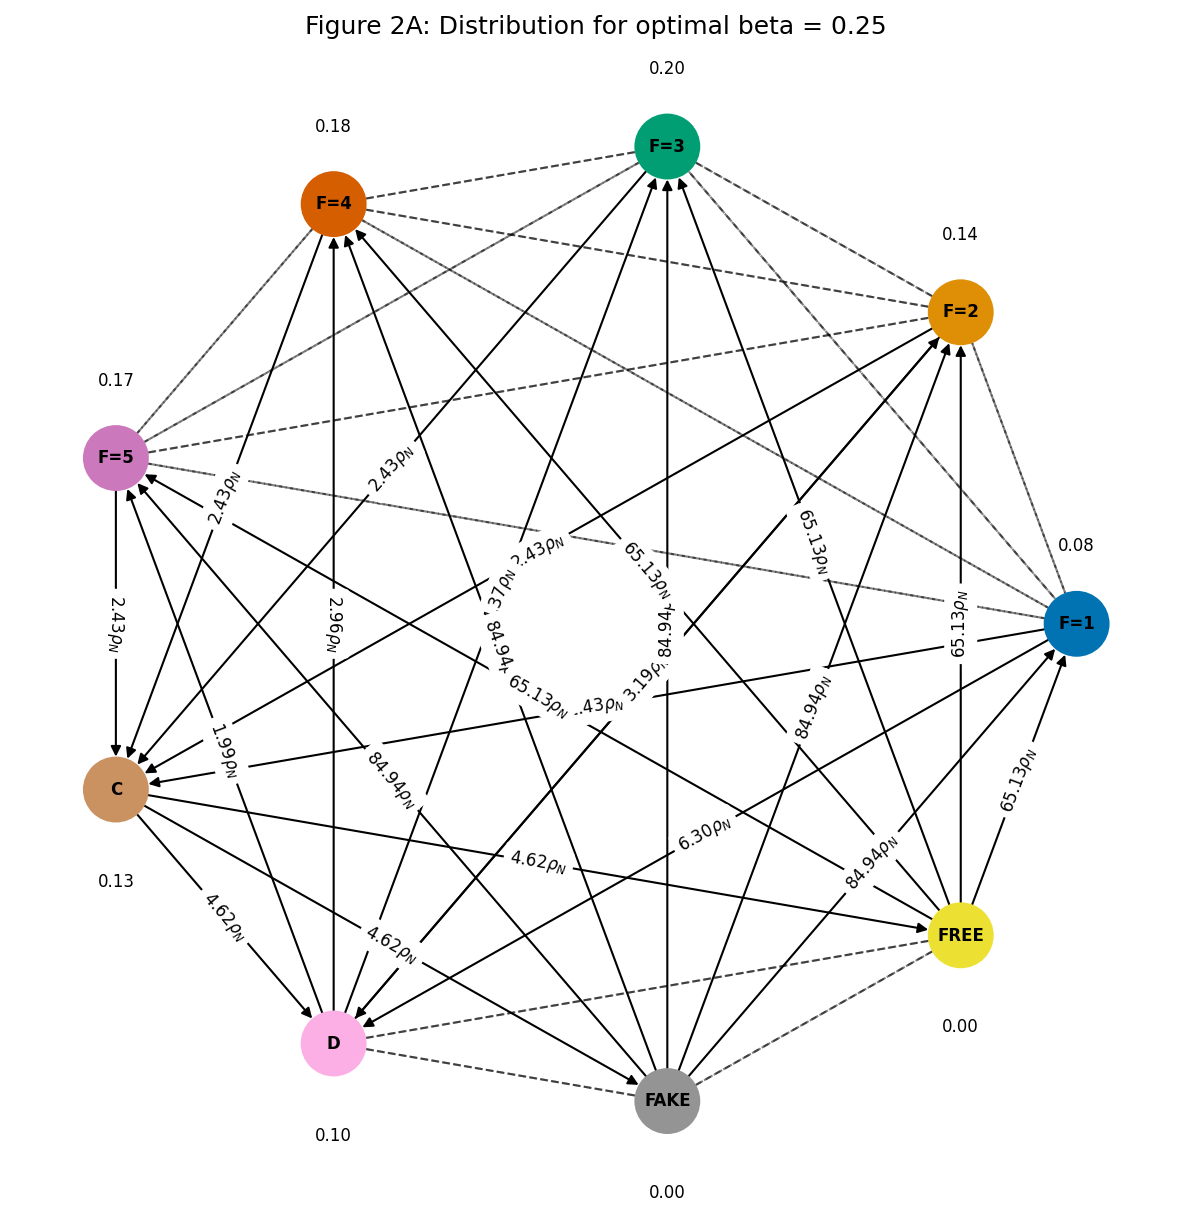

In [74]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
G = draw_invasion_diagram(strategy_labels,
                       1/Z,
                       fixation_probabilities,
                       stationary_distribution,
                       node_size=1000,
                       font_size_node_labels=8,
                       font_size_edge_labels=8,
                       font_size_sd_labels=8,
                       edge_width=1,
                       min_strategy_frequency=-0.1,
                       ax=ax)
plt.title(f"Figure 2A: Distribution for optimal beta = {0.25}")
plt.axis('off')
plt.show() # display

In [55]:
epsilon_values =[0.,1.,3.,10.,100.,1000.]
r_values = np.arange(2, 5.25, 0.25)
payoffs_r = np.zeros(shape=(len(epsilon_values),len(r_values)), dtype=np.float64)
for k in range(0,len(epsilon_values)):
  epsilon = epsilon_values[k]
  for j in range(0,len(r_values)):
    i = 0
    r = r_values[j]
    payoff_comp = (r*1.0) - 1.0 -(epsilon/5)
    payoff_C = r*1.0 - 1.0
    epsilon = epsilon_values[k]
    if(epsilon==1000.):
      game = PGGwithNormal(group_size,c,r)
    else: 
      game = PGGwithCommitment(group_size, c, r, epsilon, delta)

    evolver = PairwiseComparison(Z, game)

    transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(0.25)

    stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
    if(epsilon<1000.):
      while i <= 4:
        payoffs_r[k][j] += stationary_distribution[i] * payoff_comp
        i+=1
    payoffs_r[k][j] += stationary_distribution[i] * payoff_C


## figure 4.B

[0.20181322 0.79818678]


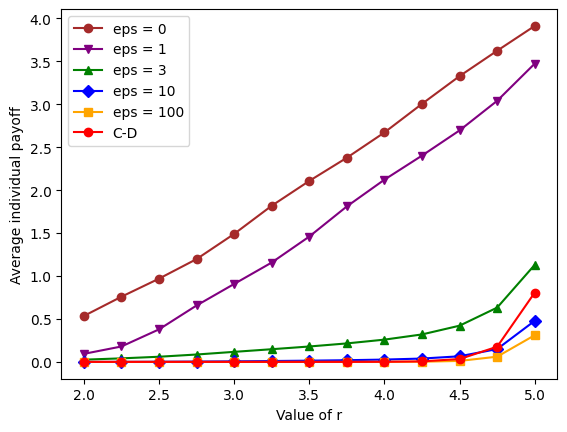

In [65]:
print(stationary_distribution)
a = [point for point in payoffs_r[0]]
b = [point for point in payoffs_r[1]]
g = [point for point in payoffs_r[2]]
d = [point for point in payoffs_r[3]]
e = [point for point in payoffs_r[4]]
f = [point for point in payoffs_r[5]]
plt.plot(r_values, a, color='brown',marker = 'o' ,label='eps = 0')
plt.plot(r_values, b, color='purple', marker = 'v' ,label='eps = 1')
plt.plot(r_values, g, color='green', marker = '^' ,label='eps = 3')
plt.plot(r_values, d, color='blue', marker = 'D' ,label='eps = 10')
plt.plot(r_values, e, color='orange',marker = 's' , label='eps = 100')
plt.plot(r_values, f, color='red',marker = 'o' , label='C-D')
plt.xlabel('Value of r')
plt.ylabel('Average individual payoff')
plt.legend()
plt.show()

## figure 4.a

In [14]:
nb_points = 7
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)
avoid_frequency_average = np.zeros((nb_points, nb_points), dtype = float)

for i, eps in enumerate(eps_values):
    for j, r in enumerate(r_values):
        game = PGGwithCommitment(group_size, c, r, eps, delta)
        evolver = PairwiseComparison(Z, game)
        transition_matrix,_ = evolver.calculate_transition_and_fixation_matrix_sml(0.25)
        stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
        
        payoff_comp = (r*1.0) - 1.0 -(eps/5)
        payoff_C = r*1.0 - 1.0
        k = 0
        while k <= 4:
            avoid_frequency_average[i,j] += stationary_distribution[k] * payoff_comp
            k+=1
        
        avoid_frequency_average[i,j] += stationary_distribution[k] * payoff_C
        print("avoid freq")
        print(avoid_frequency_average)


avoid freq
[[0.5346422 0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]]
avoid freq
[[0.5346422  0.96928881 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.       

In [47]:
nb_points = 7
eps_values = np.linspace(0., 1., nb_points)
r_values = np.linspace(2., 5., nb_points)

avoid_frequency_average = np.zeros((nb_points, nb_points), dtype = float)

for k in range(0,len(epsilon_values)):
  epsilon = epsilon_values[k]
  for j in range(0,len(r_values)):
    i = 0
    r = r_values[j]
    payoff_comp = (r*1.0) - 1.0 -(epsilon/5)
    payoff_C = r*1.0 - 1.0
    print(payoff_C)
    epsilon = epsilon_values[k]
    game = PGGwithCommitment(group_size, c, r, epsilon, delta)

    evolver = PairwiseComparison(Z, game)

    transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(0.25)

    stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())
    while i <= 4:
      avoid_frequency_average[k,j] += stationary_distribution[i] * payoff_comp
      i+=1
    avoid_frequency_average[k,j] += stationary_distribution[i] * payoff_C
    print("avoid freq")
    print(avoid_frequency_average)



1.0
avoid freq
[[0.5346422 0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]]
1.5
avoid freq
[[0.5346422  0.96928881 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0

In [78]:
r_values = np.linspace(2.0, 5.0, 13)
print(r_values)
for i in r_values:
    print(i)

[2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.   4.25 4.5  4.75 5.  ]
2.0
2.25
2.5
2.75
3.0
3.25
3.5
3.75
4.0
4.25
4.5
4.75
5.0


[[0.5346422  0.96928881 1.49029161 2.10753754 2.67190792 3.32843774
  3.91281377]
 [0.47166527 0.8962201  1.37096197 2.00319659 2.5462318  3.20531635
  3.82544049]
 [0.40655366 0.8280203  1.2632346  1.89802472 2.43904627 3.07258444
  3.7527621 ]
 [0.33215051 0.76069656 1.17149841 1.79202202 2.34883759 2.9468881
  3.68935746]
 [0.23413828 0.67951742 1.09219098 1.68291423 2.26919947 2.84256616
  3.62250871]
 [0.13771884 0.56412881 1.01256572 1.57145581 2.19503139 2.76118174
  3.54765011]
 [0.09348012 0.37857135 0.90757503 1.45973762 2.12211828 2.69606972
  3.47366771]]


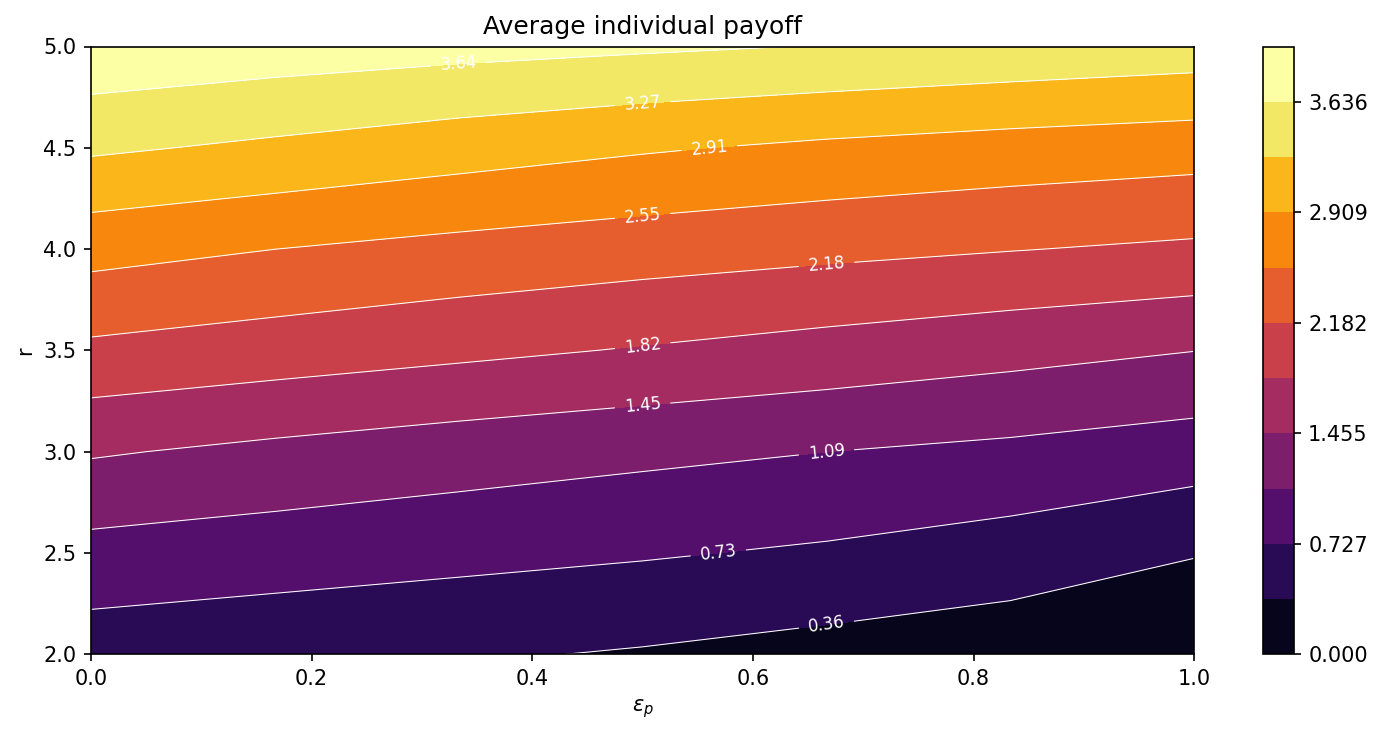

In [30]:
print(avoid_frequency_average)
levels = np.linspace(0., 4., 12)

plt.figure(figsize=(10, 5), dpi=150)
contour = plt.contourf(eps_values, r_values, avoid_frequency_average.T, levels=levels, cmap='inferno', vmin = 0., vmax = 3.7)
plt.colorbar(orientation='vertical')
contour_lines = plt.contour(eps_values, r_values, avoid_frequency_average.T, levels=levels , colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")  
plt.xlabel(r'$\epsilon_p$')
plt.ylabel("r")
plt.title("Average individual payoff")

plt.tight_layout()
plt.show()